In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls

data  vgg16_cats_dogs.h5


In [ ]:
%cd /content/drive/MyDrive/data-20251027T075134Z-1-001
! ls

/content/drive/MyDrive/data-20251027T075134Z-1-001
data  vgg16_cats_dogs.h5


In [19]:
# 匯入套件
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models, optimizers

# 資料路徑
train_dir = '/content/drive/MyDrive/data-20251027T075134Z-1-001'  # 底下要有 /cats, /dogs 資料夾
val_dir = '/content/drive/MyDrive/data-20251027T075134Z-1-001'

# 影像預處理：資料增強
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1./255)

# 建立資料生成器
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(150, 150),
    batch_size=32,
    class_mode='binary'
)

# 載入 VGG16 模型 (不包含頂層全連接層)
base_model = VGG16(weights='imagenet',
                   include_top=False,
                   input_shape=(150, 150, 3))

# 凍結預訓練權重（不訓練 VGG16 本體）
base_model.trainable = False

# 建立新模型
model = models.Sequential([
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1, activation='sigmoid')  # 兩類：貓 / 狗
])

# 編譯模型
model.compile(
    loss='binary_crossentropy',
    optimizer=optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

# 訓練模型
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator
)

# 儲存模型
model.save('cat_dog_vgg16.h5')

Found 125 images belonging to 1 classes.
Found 125 images belonging to 1 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 66s 18s/step - accuracy: 0.5551 - loss: 0.7865 - val_accuracy: 1.0000 - val_loss: 0.0155
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 74s 22s/step - accuracy: 1.0000 - loss: 0.0176 - val_accuracy: 1.0000 - val_loss: 0.0011
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 60s 17s/step - accuracy: 1.0000 - loss: 0.0014 - val_accuracy: 1.0000 - val_loss: 2.3807e-04
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 71s 21s/step - accuracy: 1.0000 - loss: 3.3052e-04 - val_accuracy: 1.0000 - val_loss: 9.3492e-05
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 60s 17s/step - accuracy: 1.0000 - loss: 9.9278e-05 - val_accuracy: 1.0000 - val_loss: 5.0782e-05
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 60s 17s/step - accuracy: 1.0000 - loss: 4.1676e-05 - val_accuracy: 1.0000 - val_loss: 3.3703e-05
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 60s 17s/step - accuracy: 1.0000 - loss: 3.4133e-05 - val_accuracy: 1.0000 - val_loss: 2.5361e-05
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 60s 17s/step - accuracy: 1.0000 - loss: 2.9138e-05 - 

In [29]:
import os
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model

# 載入訓練好的模型
model = load_model('cat_dog_vgg16.h5')

# 測試資料夾路徑
test_dir = '/content/drive/MyDrive/data-20251027T075134Z-1-001/data/test'

# 預測結果輸出
for filename in os.listdir(test_dir):
    if filename.lower().endswith(('.jpg', '.png', '.jpeg')):
        img_path = os.path.join(test_dir, filename)

        # 讀取圖片並調整尺寸
        img = image.load_img(img_path, target_size=(150, 150))
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)  # 增加批次維度
        img_array /= 255.0  # 正規化

        # 預測
        prediction = model.predict(img_array)
        if prediction[0][0] > 0.5:
            label = 'Dog 🐶'
        else:
            label = 'Cat 🐱'

        print(f"{filename} -> {label} ({prediction[0][0]:.4f})")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step
dog.jpg -> Cat 🐱 (0.0000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 355ms/step
cat.jpg -> Cat 🐱 (0.0000)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step


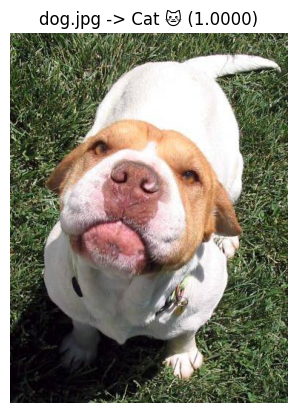

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 431ms/step


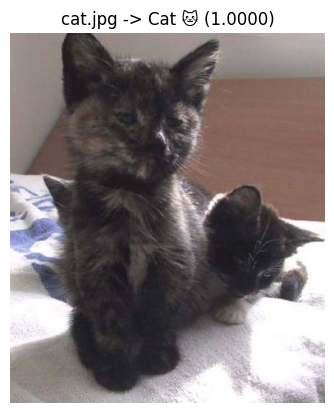

In [33]:
import os
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# 載入模型
model = load_model('cat_dog_vgg16.h5')

# 測試資料夾
test_dir = '/content/drive/MyDrive/data-20251027T075134Z-1-001/data/test'  # 這裡放你的 test 資料夾名稱

# 預測每張圖片
for filename in os.listdir(test_dir):
    if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
        img_path = os.path.join(test_dir, filename)

        # 載入圖片並轉成符合模型輸入的格式
        img = image.load_img(img_path, target_size=(150, 150))
        img_array = image.img_to_array(img) / 255.0
        img_array = np.expand_dims(img_array, axis=0)

        # 預測
        preds = model.predict(img_array)
        pred_prob = preds[0][0]

        # 判斷類別
        label = "Dog 🐶" if pred_prob > 0.5 else "Cat 🐱"
        confidence = pred_prob if pred_prob > 0.5 else 1 - pred_prob

        # 顯示圖片與預測結果
        plt.imshow(image.load_img(img_path))
        plt.axis('off')
        plt.title(f"{filename} -> {label} ({confidence:.4f})")
        plt.show()
